C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc 

In [2]:
print('Loading data ...')

train = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv("properties_2016.csv") 

# Turn float64 to float32
for c, dtype in zip(prop.columns, prop.dtypes):	
    if dtype == np.float64:		
        prop[c] = prop[c].astype(np.float32)
        
# Create the train and validation sets 
df_train = train.merge(prop, how='left', on='parcelid')
drop_cols1 = ['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode']
x_train = df_train.drop(drop_cols1, axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)


Loading data ...


C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90275, 55) (90275,)


In [3]:
x_train.shape

(90275, 55)

In [4]:
train_columns = x_train.columns
# Not sure what loop below does 
for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

# Garbage clean up - delete variables we don't need 
#del df_train; gc.collect()

# Create train and validation set 
split = 90000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
x_train = x_train.values.astype(np.float32, copy=False)
x_valid = x_valid.values.astype(np.float32, copy=False)

# Prepare data for lgbm method 
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)


### Light GBM preparation 

In [5]:
# Hyper parameters of GBM model 
params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 400
params['min_hessian'] = 1


#del d_train, d_valid; gc.collect()
#del x_train, x_valid; gc.collect()

In [6]:
# Fit the model 
watchlist = [d_valid]
clf = lgb.train(params, d_train, 500, watchlist)

[1]	valid_0's l1: 0.0721303
[2]	valid_0's l1: 0.0721337
[3]	valid_0's l1: 0.0721336
[4]	valid_0's l1: 0.0721322
[5]	valid_0's l1: 0.072133
[6]	valid_0's l1: 0.0721304
[7]	valid_0's l1: 0.0721313
[8]	valid_0's l1: 0.0721322
[9]	valid_0's l1: 0.0721324
[10]	valid_0's l1: 0.0721301
[11]	valid_0's l1: 0.0721293
[12]	valid_0's l1: 0.0721275
[13]	valid_0's l1: 0.0721276
[14]	valid_0's l1: 0.0721312
[15]	valid_0's l1: 0.072129
[16]	valid_0's l1: 0.0721305
[17]	valid_0's l1: 0.0721297
[18]	valid_0's l1: 0.0721299
[19]	valid_0's l1: 0.0721319
[20]	valid_0's l1: 0.0721315
[21]	valid_0's l1: 0.0721285
[22]	valid_0's l1: 0.0721248
[23]	valid_0's l1: 0.0721283
[24]	valid_0's l1: 0.0721305
[25]	valid_0's l1: 0.0721279
[26]	valid_0's l1: 0.0721297
[27]	valid_0's l1: 0.0721277
[28]	valid_0's l1: 0.0721286
[29]	valid_0's l1: 0.0721257
[30]	valid_0's l1: 0.0721245
[31]	valid_0's l1: 0.0721231
[32]	valid_0's l1: 0.0721243
[33]	valid_0's l1: 0.0721225
[34]	valid_0's l1: 0.0721198
[35]	valid_0's l1: 0.0721

In [7]:
clf.eval_train()

[('training', 'l1', 0.067633289585609088, False)]

### Start Feature Importance Analysis  

Feature importance can help us understand the important variables for the model 

In [8]:
feature_importance1 = pd.DataFrame(data = clf.feature_importance().T, index = train_columns, columns={"LGBM number"})
feature_importance1.head()

,LGBM number
airconditioningtypeid,35
architecturalstyletypeid,0
basementsqft,0
bathroomcnt,337
bedroomcnt,537


In [9]:
# See which features have 0 importance 
print(len(feature_importance1[feature_importance1["LGBM number"] == 0]))
feature_importance1[feature_importance1["LGBM number"]  == 0]

13


,LGBM number
architecturalstyletypeid,0
basementsqft,0
buildingclasstypeid,0
decktypeid,0
finishedsquarefeet13,0
longitude,0
poolsizesum,0
storytypeid,0
typeconstructiontypeid,0
yardbuildingsqft26,0


In [10]:
feature_importance1[feature_importance1["LGBM number"] != 0]

,LGBM number
airconditioningtypeid,35
bathroomcnt,337
bedroomcnt,537
buildingqualitytypeid,296
calculatedbathnbr,311
finishedfloor1squarefeet,94
calculatedfinishedsquarefeet,1854
finishedsquarefeet12,2128
finishedsquarefeet15,354
finishedsquarefeet50,82


We have a large variance of feature importances. The higher the better but we may want to get rid of the low importance variables for stability.  
More variables could lead to better performance at the cost of more variance in the outcome. In this case we may not want as much variance in our outcome because the test set is so much larger than the training set.  

First let's calculate the feature importance ratio for each of the variables. 

In [11]:
feat_imp_sum = feature_importance1["LGBM number"].sum()
feature_importance1["feature importance ratio"] = feature_importance1["LGBM number"].div(feat_imp_sum,axis = 0)
feature_importance1.head()

,LGBM number,feature importance ratio
airconditioningtypeid,35,0.001429
architecturalstyletypeid,0,0.000000
basementsqft,0,0.000000
bathroomcnt,337,0.013755
bedroomcnt,537,0.021918


In [12]:
feature_importance1.sort_values(["feature importance ratio"], ascending=False)

,LGBM number,feature importance ratio
finishedsquarefeet12,2128,0.086857
calculatedfinishedsquarefeet,1854,0.075673
yearbuilt,1758,0.071755
structuretaxvaluedollarcnt,1727,0.070490
regionidzip,1685,0.068776
lotsizesquarefeet,1636,0.066776
taxvaluedollarcnt,1453,0.059306
regionidneighborhood,1296,0.052898
taxamount,1281,0.052286
rawcensustractandblock,1276,0.052082


Interesting that the variable with the most importance about 8% of the total.  
There are a lot of values with very low feature importance as well.  
Let's arbitrarily take out the variables with less than 1% of the feature importance 

In [13]:
# Number of features with relative ratio greater than 1% 
len(feature_importance1[feature_importance1["feature importance ratio"] > 0.005])

27

In [14]:
feature_importance1[feature_importance1["feature importance ratio"] > 0.005]

,LGBM number,feature importance ratio
bathroomcnt,337,0.013755
bedroomcnt,537,0.021918
buildingqualitytypeid,296,0.012082
calculatedbathnbr,311,0.012694
calculatedfinishedsquarefeet,1854,0.075673
finishedsquarefeet12,2128,0.086857
finishedsquarefeet15,354,0.014449
fullbathcnt,153,0.006245
garagetotalsqft,322,0.013143
heatingorsystemtypeid,408,0.016653


In [15]:
low_feat_imp_variables = feature_importance1[feature_importance1["feature importance ratio"] < 0.005].index
# add low feature importance variables to the identifiers (and other variables we don't want in ) 
drop_cols2 = low_feat_imp_variables.append(pd.Index(drop_cols1))

In [16]:
# Make a new training dataset (from original imported dataset )
x_train1 = df_train.drop(drop_cols2, axis = 1)
x_train1.shape

(90275, 27)

In [17]:
train_columns = x_train1.columns
y_train =  df_train['logerror'].values
# Not sure what this loop does 
for c in x_train1.dtypes[x_train1.dtypes == object].index.values:
    x_train1[c] = (x_train1[c] == True)

#del df_train; gc.collect()

#Recreate the training and test datasets with only the new columns we want 
split = 90000
x_train2, y_train2, x_valid2, y_valid2 = x_train1[:split], y_train[:split], x_train1[split:], y_train[split:]
x_train2 = x_train2.values.astype(np.float32, copy=False)
x_valid2 = x_valid2.values.astype(np.float32, copy=False)

d_train2 = lgb.Dataset(x_train2, label=y_train2)
d_valid2 = lgb.Dataset(x_valid2, label=y_valid2)

In [18]:
x_train2.shape

(90000, 27)

In [19]:
y_train.shape

(90275,)

In [20]:
print(y_valid2.shape)
print(x_valid2.shape)

(275,)
(275, 27)


In [21]:
print(x_train2.shape)
print(y_train2.shape)

(90000, 27)
(90000,)


In [22]:
# Train new model with fewer variables 
watchlist = [d_valid2]
clf1 = lgb.train(params, d_train2, 500, watchlist)

[1]	valid_0's l1: 0.07213
[2]	valid_0's l1: 0.0721292
[3]	valid_0's l1: 0.0721292
[4]	valid_0's l1: 0.0721272
[5]	valid_0's l1: 0.0721263
[6]	valid_0's l1: 0.0721235
[7]	valid_0's l1: 0.0721218
[8]	valid_0's l1: 0.0721227
[9]	valid_0's l1: 0.0721227
[10]	valid_0's l1: 0.0721228
[11]	valid_0's l1: 0.0721236
[12]	valid_0's l1: 0.0721248
[13]	valid_0's l1: 0.0721246
[14]	valid_0's l1: 0.0721254
[15]	valid_0's l1: 0.0721261
[16]	valid_0's l1: 0.0721257
[17]	valid_0's l1: 0.072123
[18]	valid_0's l1: 0.0721232
[19]	valid_0's l1: 0.072125
[20]	valid_0's l1: 0.072126
[21]	valid_0's l1: 0.0721282
[22]	valid_0's l1: 0.0721272
[23]	valid_0's l1: 0.0721248
[24]	valid_0's l1: 0.0721234
[25]	valid_0's l1: 0.0721178
[26]	valid_0's l1: 0.0721167
[27]	valid_0's l1: 0.0721177
[28]	valid_0's l1: 0.0721196
[29]	valid_0's l1: 0.0721175
[30]	valid_0's l1: 0.0721183
[31]	valid_0's l1: 0.0721178
[32]	valid_0's l1: 0.0721173
[33]	valid_0's l1: 0.0721145
[34]	valid_0's l1: 0.0721131
[35]	valid_0's l1: 0.0721139

In [23]:
clf1.eval_train()

[('training', 'l1', 0.067663857295373872, False)]

### Let's do some analysis on the model errors 

In [24]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

In [25]:
# Look at the distributions for the output and our predictions 
scores = pd.Series(clf1.predict(x_train))
print("Score Quantiles: \n", scores.quantile(q = [0.25, 0.5, 0.75]))
print("Actual Quantiles: \n", pd.Series(y_train).quantile(q = [0.25, 0.5, 0.75]))

Score Quantiles: 
 0.25   -0.003186
0.50    0.000541
0.75    0.001536
dtype: float64
Actual Quantiles: 
 0.25   -0.0253
0.50    0.0060
0.75    0.0392
dtype: float64


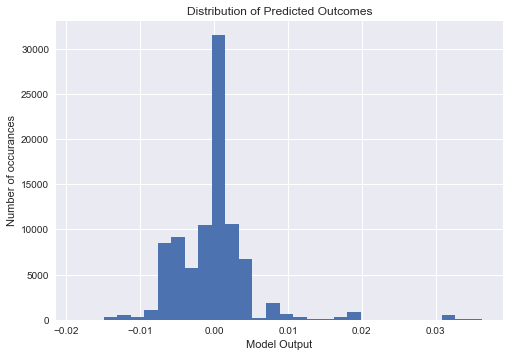

In [26]:
plt.hist(scores, bins=30)
plt.title("Distribution of Predicted Outcomes")
plt.xlabel("Model Output")
plt.ylabel("Number of occurances")

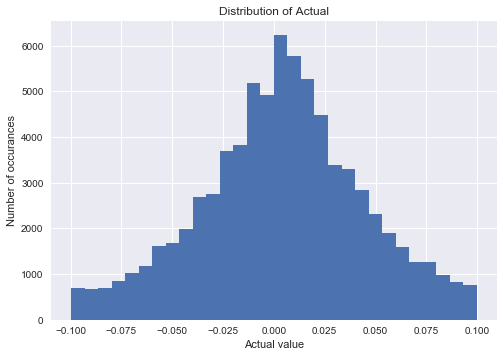

In [27]:
plt.hist(y_train[abs(y_train) < 0.1], bins = 30)
plt.title("Distribution of Actual")
plt.xlabel("Actual value")
plt.ylabel("Number of occurances")

Looks like something is going wrong. It could be beacuse we used the default hyper parameters from the previous notebook.  
We should try another model with better hyper paramters. 

### Light GBM Cross Validation  

Let's use a grid search and cross validation to find the best set of hyper paramters for the model.  

In [28]:
# Set parameters that will be the same for all the cross validated models 

params2 = {}
#params2['learning_rate'] = 0.002
params2['boosting_type'] = 'gbdt'
params2['objective'] = 'regression'
params2['metric'] = 'mae'
params2['sub_feature'] = 0.5
#params2['num_leaves'] = 50
#params2['min_data'] = 400
params2['min_hessian'] = 1

In [29]:
# Use the lgbm sci kit learn wrapper (so we can use grid search cv)
estimator = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric = 'mae')

In [30]:
# initial grid for hyper parameters 
param_grid2 = {
    'learning_rate': [0.001, 0.01, 0.1], 
    'n_estimators': [20, 30, 50, 100], 
    'num_leaves': [10, 30, 60],
    'min_data': [300, 500, 700]
}
# Signing up for 3*4*3*3 models  = 108 models 

In [31]:
from sklearn.model_selection import GridSearchCV


In [32]:
# Prepare for cross validation 
gbm_grid = GridSearchCV(estimator, param_grid2, cv = 4)

In [33]:
# Fit the gbm model 
gbm_grid.fit(x_train2, y_train2)
#gbm_grid.cv_results_

GridSearchCV(cv=4, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
       max_bin=255, max_depth=-1, metric='mae', min_child_samples=10,
       min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
       num_leaves=31, objective='regression', reg_alpha=0, reg_lambda=0,
       seed=0, silent=True, subsample=1, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 50, 100], 'min_data': [300, 500, 700], 'learning_rate': [0.001, 0.01, 0.1], 'num_leaves': [10, 30, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
gbm_grid.best_params_

{'learning_rate': 0.1, 'min_data': 300, 'n_estimators': 100, 'num_leaves': 10}

In [35]:
gbm_grid.best_score_

0.013013503888049645

In [36]:
gbm_grid.cv_results_.keys() 

dict_keys(['split0_test_score', 'std_fit_time', 'split3_train_score', 'param_num_leaves', 'std_train_score', 'param_n_estimators', 'split2_test_score', 'split3_test_score', 'mean_train_score', 'param_min_data', 'std_score_time', 'params', 'mean_test_score', 'split1_test_score', 'split1_train_score', 'split2_train_score', 'mean_score_time', 'mean_fit_time', 'rank_test_score', 'param_learning_rate', 'std_test_score', 'split0_train_score'])

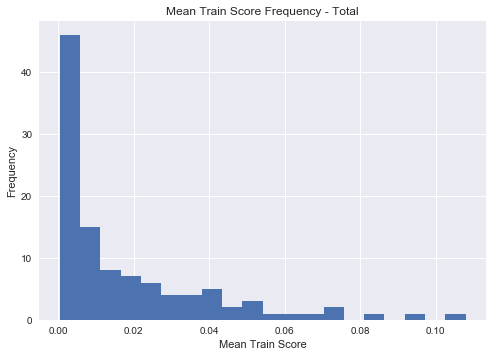

In [37]:
plt.hist(gbm_grid.cv_results_["mean_train_score"], bins = 20) 
plt.xlabel("Mean Train Score")
plt.title("Mean Train Score Frequency - Total")
plt.ylabel("Frequency")

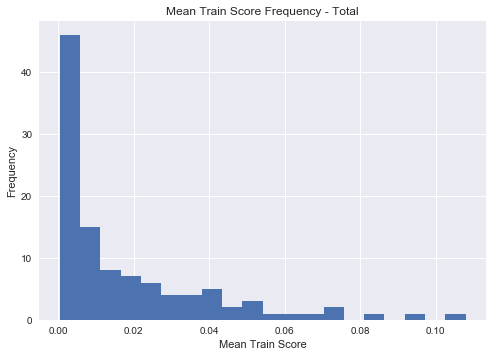

In [38]:
plt.hist(gbm_grid.cv_results_["mean_train_score"], bins = 20) 
plt.xlabel("Mean Train Score")
plt.title("Mean Train Score Frequency - Total")
plt.ylabel("Frequency")

In [39]:
gbm_grid_score002 = gbm_grid.cv_results_["mean_train_score"][gbm_grid.cv_results_["mean_train_score"] < 0.02]
len(gbm_grid.cv_results_["mean_train_score"][gbm_grid.cv_results_["mean_train_score"] < 0.02])

74

In [40]:
lowest_train_score1 = min(gbm_grid.cv_results_["mean_train_score"])
min(gbm_grid.cv_results_["mean_train_score"])

0.00034959718352914337

In [41]:
# Number of scores within 20% of the lowest train score 
len(gbm_grid.cv_results_["mean_train_score"][gbm_grid.cv_results_["mean_train_score"] < (lowest_train_score1+ 0.20* lowest_train_score1)])

3

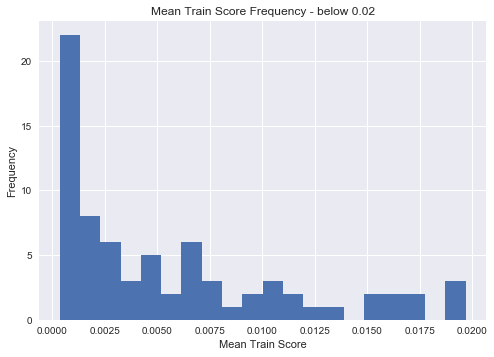

In [42]:
plt.hist(gbm_grid_score002, bins = 20) 
plt.xlabel("Mean Train Score")
plt.title("Mean Train Score Frequency - below 0.02")
plt.ylabel("Frequency")

In [44]:
#gbm_grid.cv_results_[gbm_grid.cv_results_["mean_train_score"] == min(gbm_grid.cv_results_["mean_train_score"])]

In [45]:
for key_name in gbm_grid.cv_results_.keys():
    if key_name == 'params':
        print("params...")
    else:
        key_value = gbm_grid.cv_results_[key_name][gbm_grid.cv_results_["mean_train_score"] == min(gbm_grid.cv_results_["mean_train_score"])]
        print(key_name, " : ", key_value )

split0_test_score  :  [ -2.60259953e-05]
std_fit_time  :  [ 0.03577845]
split3_train_score  :  [ 0.00035588]
param_num_leaves  :  [10]
std_train_score  :  [  1.50041526e-05]
param_n_estimators  :  [20]
split2_test_score  :  [ 0.00024518]
split3_test_score  :  [-0.00103471]
mean_train_score  :  [ 0.0003496]
param_min_data  :  [700]
std_score_time  :  [ 0.01018885]
params...
mean_test_score  :  [-0.00072133]
split1_test_score  :  [-0.00206976]
split1_train_score  :  [ 0.00032549]
split2_train_score  :  [ 0.00035073]
mean_score_time  :  [ 0.03077143]
mean_fit_time  :  [ 0.35475302]
rank_test_score  :  [106]
param_learning_rate  :  [0.001]
std_test_score  :  [ 0.00091297]
split0_train_score  :  [ 0.00036628]


In [46]:
test_value = max(gbm_grid.cv_results_["mean_test_score"])
print("Test Value: ",test_value)
for key_name in param_grid2.keys():
    new_key_name = 'param_'+ key_name
    key_value = gbm_grid.cv_results_[new_key_name][gbm_grid.cv_results_["mean_test_score"] == test_value]
    print(key_name, " : ", key_value )

Test Value:  0.013013503888
n_estimators  :  [100]
min_data  :  [300]
learning_rate  :  [0.1]
num_leaves  :  [10]


In [47]:
param_grid2


{'learning_rate': [0.001, 0.01, 0.1],
 'min_data': [300, 500, 700],
 'n_estimators': [20, 30, 50, 100],
 'num_leaves': [10, 30, 60]}

In [48]:
gbm_grid.best_params_

{'learning_rate': 0.1, 'min_data': 300, 'n_estimators': 100, 'num_leaves': 10}

In [49]:
# Finer grid based on previous values 
param_grid3 = {
    'learning_rate': [0.05, 0.1, 0.15], 
    'n_estimators': [125, 175, 250], 
    'num_leaves': [13,15, 20], 
    'min_data': [150, 225, 300]
}

In [50]:
gbm_grid3 = GridSearchCV(estimator, param_grid3, cv = 5)
gbm_grid3.fit(x_train2, y_train2)
#gbm_grid.cv_results_

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
       max_bin=255, max_depth=-1, metric='mae', min_child_samples=10,
       min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
       num_leaves=31, objective='regression', reg_alpha=0, reg_lambda=0,
       seed=0, silent=True, subsample=1, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [125, 175, 250], 'min_data': [150, 225, 300], 'learning_rate': [0.05, 0.1, 0.15], 'num_leaves': [13, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [51]:
gbm_grid3.cv_results_.keys() 

dict_keys(['split0_test_score', 'std_fit_time', 'split3_train_score', 'param_num_leaves', 'std_train_score', 'param_n_estimators', 'split2_test_score', 'split3_test_score', 'split4_train_score', 'split4_test_score', 'param_min_data', 'std_score_time', 'params', 'mean_test_score', 'split1_test_score', 'split1_train_score', 'split2_train_score', 'mean_score_time', 'mean_fit_time', 'rank_test_score', 'param_learning_rate', 'mean_train_score', 'std_test_score', 'split0_train_score'])

In [52]:
print("Refined Grid Best Details")
print(gbm_grid3.best_params_)
print(gbm_grid3.best_score_) 

Refined Grid Best Details
{'n_estimators': 250, 'num_leaves': 13, 'learning_rate': 0.05, 'min_data': 300}
0.0151310466042


In [53]:
print("First Grid Best Details")
print(gbm_grid.best_params_)
print(gbm_grid.best_score_) 

First Grid Best Details
{'n_estimators': 100, 'num_leaves': 10, 'learning_rate': 0.1, 'min_data': 300}
0.013013503888


In [54]:
min(gbm_grid3.cv_results_['mean_train_score'])

0.034871931584509762

In [55]:
#print("Mean: ", gbm_grid3.cv_results_['mean_train_score'])
#print("Std: ", gbm_grid3.cv_results_['std_train_score'])
len(gbm_grid3.cv_results_['mean_train_score'])

81

In [56]:
gbm_grid3.cv_results_.keys()

dict_keys(['split0_test_score', 'std_fit_time', 'split3_train_score', 'param_num_leaves', 'std_train_score', 'param_n_estimators', 'split2_test_score', 'split3_test_score', 'split4_train_score', 'split4_test_score', 'param_min_data', 'std_score_time', 'params', 'mean_test_score', 'split1_test_score', 'split1_train_score', 'split2_train_score', 'mean_score_time', 'mean_fit_time', 'rank_test_score', 'param_learning_rate', 'mean_train_score', 'std_test_score', 'split0_train_score'])

In [57]:
min(gbm_grid3.cv_results_['mean_train_score'])

0.034871931584509762

In [76]:
best_params = {}

best_params['learning_rate'] = 0.0001
best_params['boosting_type'] = 'gbdt'
best_params['objective'] = 'regression'
best_params['metric'] = 'mae'
best_params['sub_feature'] = 0.5
best_params['num_leaves'] = 30
best_params['min_data'] = 300
best_params['min_hessian'] = 1

In [77]:
x_train_best = df_train.drop(drop_cols2, axis=1)
y_train_best = df_train['logerror'].values
DS_best = lgb.Dataset(x_train_best, label=y_train_best)


In [78]:
clf_best = lgb.train(best_params, DS_best, 1000)

In [67]:
clf_best.eval_train()

[('training', 'l1', 0.065821061977437312, False)]

In [71]:
final_x_variables = x_train_best.columns


In [74]:

print("Prepare for the prediction ...")
sample = pd.read_csv("sample_submission.csv")
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')
#del sample, prop; gc.collect()
x_test = df_test[final_x_variables]
del df_test; gc.collect()
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
x_test = x_test.values.astype(np.float32, copy=False)


Prepare for the prediction ...


In [75]:
print("Start prediction ...")
# num_threads > 1 will predict very slow in kernal
clf.reset_parameter({"num_threads":1})
p_test = clf_best.predict(x_test, num_iteration= clf1.best_iteration)

#del x_test; gc.collect()

print("Start write result ...")
sub = pd.read_csv("sample_submission.csv")
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

sub.to_csv('lgb_starter3.csv', index=False, float_format='%.4f')

Start prediction ...
Start write result ...
